In [27]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.nn.init as init
from tensorboardX import SummaryWriter

import torchvision
from torchvision import transforms

import matplotlib
%matplotlib notebook
import matplotlib.pyplot as plt
import matplotlib.colors as colors

import os
import pickle
import logging
eps = np.finfo(np.float32).eps
os.environ["CUDA_VISIBLE_DEVICES"] = '0'

In [2]:
class MaskedConv2d(nn.Conv2d):

    def __init__(self, in_channels, out_channels, kernel_size, mode, prev_m, img_channels=3, stride=1, bias=True, m=None):
#         super(MaskedConv2d, self).__init__(in_channels, out_channels, kernel_size, stride,
#                  padding=0, dilation=0, groups=1, bias=bias, padding_mode='zeros')
        super(MaskedConv2d, self).__init__(in_channels, out_channels, kernel_size, stride,
             padding=0, dilation=0, groups=1, bias=bias)
        
        # Vector used to decide the auto-regressive order (we refer to this vector as mask indicator vector below).
        # Used for generating mask. This technique is described in the MADE paper (https://arxiv.org/abs/1502.03509)
        if m is None:
            self.register_buffer("m", torch.from_numpy(np.random.randint(0, img_channels, [out_channels])).float())
        else:
            self.register_buffer("m", m)
            
        self.register_buffer("mask", torch.ones_like(self.weight))
        self.set_mask(mode, prev_m)
        
    def forward(self, x):
        p2d = (self.kernel_size[0] // 2, self.kernel_size[0] // 2, self.kernel_size[1] // 2, self.kernel_size[1] // 2)
        return F.conv2d(F.pad(x, p2d), self.mask * self.weight, self.bias, self.stride)

    def set_mask(self, mode, prev_m):
        """ Generate mask according to the mask indicator vector of the input and current layer.
        Args
            mode: 'a' or 'b'
            prev_m: mask vector of the input.
        """
        if mode != 'a' and mode != 'b':
            raise ValueError("Mask mode should be 'a' or 'b'.")
            
        center_h, center_w = self.kernel_size[0] // 2, self.kernel_size[1] // 2
        
        self.mask.data = torch.ones_like(self.weight, dtype=torch.float32)
        self.mask[:, :, center_h, center_w:] = 0.0
        if center_h + 1 < self.kernel_size[0]:
            self.mask[:, :, center_h + 1:, :] = 0.0
        
        if mode == 'a':
            self.mask[:, :, center_h, center_w] = self.m.view(-1, 1) > prev_m.view(1, -1)
        elif mode == 'b':
            self.mask[:, :, center_h, center_w] = self.m.view(-1, 1) >= prev_m.view(1, -1)

In [3]:
class ResidualBlock(nn.Module):
    
    def __init__(self, in_channels, prev_m, mode='b', img_channels=3):
        super(ResidualBlock, self).__init__()
        self.h = in_channels // 2
        self.in_channels = in_channels
        
        self.mask_conv1 = MaskedConv2d(in_channels, self.h, [1, 1], mode, prev_m, img_channels)
        self.bn_1 = nn.BatchNorm2d(self.h)
        self.mask_conv2 = MaskedConv2d(self.h, self.h, [3, 3], mode, self.mask_conv1.m, img_channels)
        self.bn_2 = nn.BatchNorm2d(self.h)

        # The last layer must have the same mask vector as the input layer so that they can add up together while
        # preserving the auto-regressive order.
        self.mask_conv3 = MaskedConv2d(self.h, in_channels, [1, 1], mode, self.mask_conv2.m, img_channels, m=prev_m)
        self.last_m = self.mask_conv3.m 
        self.bn_3 = nn.BatchNorm2d(in_channels)
        
    def forward(self, x):
        out = self.bn_1(self.mask_conv1(F.relu(x)))
        out = self.bn_2(self.mask_conv2(F.relu(out)))
        out = self.bn_3(self.mask_conv3(F.relu(out))) + x
        return out

In [4]:
class PixelCNN(nn.Module):
    
    def __init__(self, h, n_channels=3, n_classes=256):
        """
        Args
            h: hidden size
            n_classes: possible values of a pixel.
        """
        super(PixelCNN, self).__init__()
        self.h = h
        self.n_channels = n_channels
        self.n_classes = n_classes
        
        self.init_m = torch.from_numpy(np.array(list(np.arange(n_channels)))).float()
        self.mask_conv1 = MaskedConv2d(n_channels, 2 * h, [7, 7], 'a', self.init_m, n_channels)
        
        self.residuals = nn.ModuleList()
        prev_m = self.mask_conv1.m 
        for i in range(12):
            self.residuals.append(ResidualBlock(2 * h, prev_m, 'b', n_channels))
            prev_m = self.residuals[-1].last_m
        self.mask_conv2 = MaskedConv2d(2 * h, 2 * h, [1, 1], 'b', self.residuals[-1].last_m, n_channels)

        out_m = []
        for i in range(n_channels):
            out_m.extend([i] * n_classes)
        self.mask_conv3 = MaskedConv2d(2 * h, n_classes * n_channels, [1, 1], 'b', self.mask_conv2.m, n_channels,
                                       m=torch.from_numpy(np.array(out_m)).float())
        
    def forward(self, x):
        out = self.mask_conv1(x)
        for res in self.residuals:
            out = res(out)
        out = self.mask_conv2(F.relu(out))
        out = self.mask_conv3(F.relu(out))

        logits = out.view([x.shape[0], x.shape[1], self.n_classes, x.shape[2], x.shape[3]]).permute([0, 2, 1, 3, 4])
        out = F.softmax(logits, dim=1)  # [N, n_classes, C, H, W]
        return logits, out

    
    def sample_once(self):
        x = torch.zeros([1, self.n_channels, 28, 28]).float()
        if next(self.parameters()).is_cuda:
            x = x.cuda()
        for i in range(28):
            for j in range(28):
                for k in range(self.n_channels):
                    _, distrib = self.forward(x)
#                     print(distrib[0, k, :, i, j].cpu().data.numpy())
                    x[0, k, i, j] = np.random.choice(self.n_classes, p=distrib[0, :, k, i, j].cpu().data.numpy())
        return x.detach()

In [5]:
def save_checkpoint(state, save_dir, ckpt_name):
    if not os.path.exists(save_dir):
        os.mkdir(save_dir)
        print("Save directory dosen't exists. Making directory {}".format(save_dir))
    save_path = os.path.join(save_dir, ckpt_name)
    torch.save(state, save_path)
    
    
def load_checkpoint(model, checkpoint):
    if not os.path.exists(checkpoint):
        raise FileNotFoundError("Checkpoint {} dosen't exists!".format(checkpoint))

    ckpt = torch.load(checkpoint)
    new_state_dict = model.state_dict()
    new_state_dict.update(ckpt['state_dict'])
    model.load_state_dict(new_state_dict)
    
    
def set_logger(file_path):
    logger = logging.getLogger()
    logger.setLevel(logging.INFO)
    
    if not logger.handlers:
        file_handler = logging.FileHandler(file_path)
        file_handler.setFormatter(logging.Formatter("%(asctime)s:%(levelname)s:%(message)s"))
        logger.addHandler(file_handler)
        
        stream_handler = logging.StreamHandler()
        stream_handler.setFormatter(logging.Formatter("%(asctime)s:%(message)s"))
        logger.addHandler(stream_handler)

In [6]:
# split train-val-test
with open('./mnist-hw1.pkl', 'rb') as f:
    X = pickle.load(f)
l = X['train'].shape[0]
idx = np.random.permutation(l)
img_train = X['train'][idx[:int(l * 0.8)]].transpose([0, 3, 1, 2])
img_val = X['train'][idx[int(l * 0.8):]].transpose([0, 3, 1, 2])
img_test = X['test'].transpose([0, 3, 1, 2])

In [7]:
torch.cuda.empty_cache()
n_epochs = 50
batch_size = 128
n_iter_per_epoch = img_train.shape[0] // batch_size
val_batch_size = 128

lr = 1e-3
save_dir = './pixelCNN-Log'
if not os.path.exists(save_dir):
    os.mkdir(save_dir)
set_logger(os.path.join(save_dir, 'train.log'))

train_log = [] 
val_log = []

net = PixelCNN(128, 3, 4).cuda()
# optimizer = optim.RMSprop(net.parameters(), lr=lr)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.1, patience=15, verbose=True, eps=eps) 
# # scheduler = optim.lr_scheduler.StepLR(optimizer, step=800, factor=0.5, patience=300, verbose=True, eps=eps) 
optimizer = optim.Adam(net.parameters(), lr=lr, amsgrad=True)
eval_steps = 125

min_bits = np.inf
writer = SummaryWriter(os.path.join(save_dir, "summary"), comment="test")

In [ ]:
for i in range(n_epochs):
    idx = np.random.permutation(img_train.shape[0])
    for j in range(n_iter_per_epoch):
        global_step = i * n_iter_per_epoch + (j + 1)
        net.train()
        train_batch = torch.from_numpy(img_train[idx[batch_size * j : batch_size * (j + 1)]]).float().cuda()
        logits, distrib = net(train_batch)
        
        loss = F.cross_entropy(logits, train_batch.long(), reduction='sum') / batch_size 
        writer.add_scalar("loss", loss.item(), global_step)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_bits = loss.detach() / np.log(2.0) / (28 * 28 * 3)
        train_log.append(train_bits)
        logging.info("Epoch {:d}/{:d} Iter {:d}/{:d} Loss {:.5f}, train-bits {:.5f}"
                     .format(i + 1, n_epochs, j + 1, n_iter_per_epoch, loss.item(), train_bits.item()))

        writer.add_scalar("train_bits", train_bits.item(), global_step)
        
        if global_step % eval_steps == 0:
             with torch.no_grad():
                net.eval()
                val_bits = 0
                for k in range(img_val.shape[0] // val_batch_size):
                    val_batch = torch.from_numpy(img_val[k * val_batch_size: (k + 1) * val_batch_size]).float().cuda()
                    val_logits, val_distrib = net(val_batch)
                    val_bits = val_bits + F.cross_entropy(val_logits, val_batch.long(), reduction='sum')
                val_bits = val_bits / img_val.shape[0] / np.log(2.0) / (28 * 28 * 3)
                val_log.append(val_bits)

                logging.info("Eval result {:.5f} (bits/dim)".format(val_bits.item()))
                writer.add_scalar("val_bits", val_bits.item(), global_step)
            
                if min_bits > val_bits:
                    min_bits = val_bits
                    save_checkpoint({"Epoch": i + 1, "Iter": j + 1, "state_dict": net.state_dict()}, \
                                    save_dir, 'best.pth.tar')
            
#                 scheduler.step(val_bits)

save_checkpoint({"Epoch": i + 1, "Iter": j + 1, "state_dict": net.state_dict()}, \
                save_dir, 'last.pth.tar')

In [12]:
with open(os.path.join(save_dir, 'train.log'), 'wb') as f:
    pickle.dump(train_log, f)
with open(os.path.join(save_dir, 'val.log'), 'wb') as f:
    pickle.dump(val_log ,f)

<IPython.core.display.Javascript object>


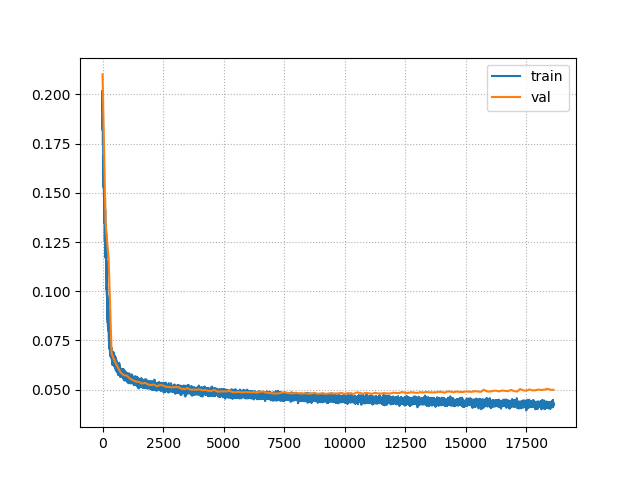

In [29]:
plt.plot(np.arange(len(train_log) - 125), train_log[125:], label='train')
plt.plot(np.arange(len(val_log)) * eval_steps, val_log, label='val')
plt.legend()
plt.xlabel("Iterations")
plt.ylabel("Bits per dim")
plt.grid(linestyle=':')

In [24]:
load_checkpoint(net, os.path.join(save_dir, './best.pth.tar'))

In [30]:
test_batch_size = 128
with torch.no_grad():
    net.eval()
    test_bits = 0
    for k in range(img_test.shape[0] // test_batch_size):
        test_batch = torch.from_numpy(img_test[k * test_batch_size: (k + 1) * test_batch_size]).float().cuda()
        test_logits, test_distrib = net(test_batch)
        test_bits = test_bits + F.cross_entropy(test_logits, test_batch.long(), reduction='sum')
    test_bits = test_bits / img_test.shape[0] / np.log(2.0) / (28 * 28 * 3)
print(test_bits)

tensor(0.0478, device='cuda:0')


### Sample images

In [ ]:
# This will take some time (about 40 min)
load_checkpoint(net, os.path.join(save_dir, './best.pth.tar'))
sampled_img = np.zeros([100, 3, 28, 28])
with torch.no_grad():
    for i in range(100):
        s = net.sample_once()
        s = s.cpu().data.numpy()
        sampled_img[i] = s
with open(os.path.join(save_dir, 'sampled_img.pkl'), 'wb') as f:
    pickle.dump(sampled_img, f)

<IPython.core.display.Javascript object>


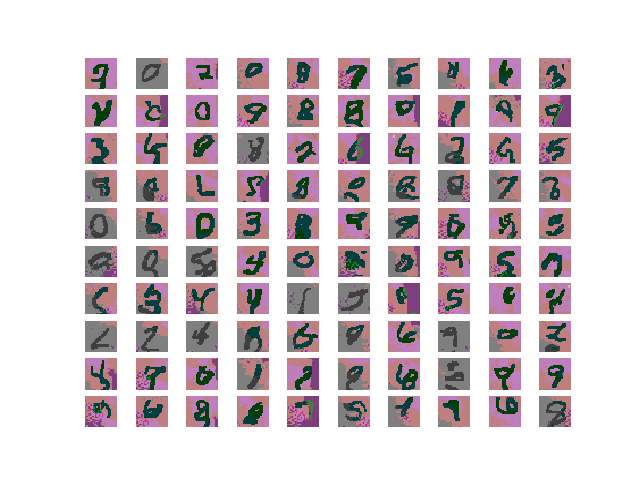

In [36]:
with open(os.path.join(save_dir, 'sampled_img.pkl'), 'rb') as f:
    sampled_img = pickle.load(f)
for i in range(10):
    for j in range(10):
        idx = i * 10 + j + 1
        plt.subplot(10, 10, idx)
        plt.imshow(sampled_img[idx - 1].transpose([1, 2, 0]) / 4.0)
        plt.axis('off')

### Receptive field visualization

In [75]:
net = PixelCNN(128, 3, 4).cuda()
train_batch = torch.ones([1, 3, 28, 28]).float().cuda()
train_batch.requires_grad = True
_, distrib = net(train_batch)
loss = torch.sum(torch.gather(distrib[0, :, 0, 14, 14], 0, train_batch[0, 0, 14, 14].long()))
optimizer.zero_grad()
loss.backward()

<IPython.core.display.Javascript object>


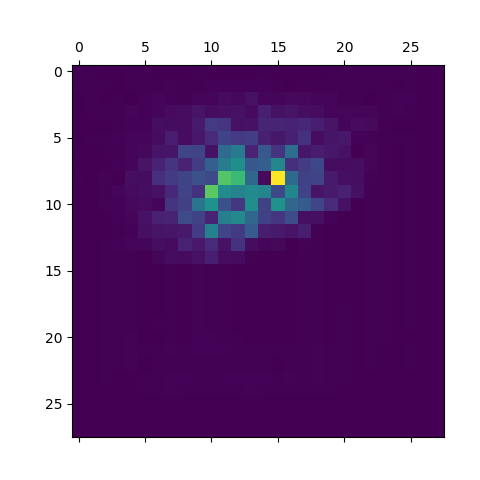

In [77]:
g = train_batch.grad[0, :, :, :].cpu().data.numpy()
g = np.max(np.abs(g), axis=0)
plt.matshow(g)